#### Importando as bibliotecas

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, BSpline

In [7]:
def plotar_grafico_colunas(rmse_values, nome):
    labels = ['Interp BSPline', 'Interp. Linear', 'Interp. Ponderada no Tempo', 'KNN', 'Média Móvel', 'Mediana Móvel']
    label_font_size = 6
    colors = ['#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51', '#5c5034']
    # colors = ['#ce593d', '#af5941', '#5aa5a9', '#07375b', '#5c5034']
    plt.bar(labels, rmse_values, color=colors)
    plt.xticks(fontsize=label_font_size)
    #plt.ylim(ymax=20000000)
    plt.xlabel('Métodos')
    plt.ylabel('Acurácia')
    plt.title('Valores Acurácia ' +  nome)

In [19]:
def imputacao_spline(df):
    data_df = df[df['Vazao'] != -1].copy()
    data_df
    smoothing = 0
    spline_degree = 3

    x = data_df.index
    y = data_df['Vazao']

    # Criando o BSpline
    t, c, k = splrep(x, y, s=smoothing, k=spline_degree)
    spline = BSpline(t, c, k)

    # Criando o intervalo de interpolação
    knot_distance = 10
    x_new = np.linspace(0, (len(df)-2), (len(df)-2) * knot_distance)

    # Calculando a interpolação no novo intervalo
    y_fit = spline(x_new)

    dados_faltantes = df[df['Vazao'] == -1].copy()
    dados_faltantes['Vazao Sintetica'] = spline(dados_faltantes.index)

    reconstrucao_df = df.copy()

    for index in reconstrucao_df[reconstrucao_df['Vazao'] == -1].index:
        interpolacao = spline(index)
        reconstrucao_df.loc[index, 'Vazao'] = interpolacao

    return reconstrucao_df


In [6]:
def calcular_rmse(dados_originais, dados_processados):

        data = {'Valor_Real': dados_originais,
        'Valor_Previsto': dados_processados}

        df = pd.DataFrame(data)
        
        # Calcule as diferenças entre os valores reais e previstos
        df['Diferenca'] = df['Valor_Real'] - df['Valor_Previsto']

        # Eleve ao quadrado as diferenças
        df['Diferenca_Quadrada'] = df['Diferenca'] ** 2

        # Calcule a média das diferenças ao quadrado
        mse = df['Diferenca_Quadrada'].mean()

        # Calcule a raiz quadrada do MSE para obter o RMSE
        rmse = np.sqrt(mse)

        return rmse

In [5]:
def plot_vazao(df):
    valid_vazao = df[df['original'] != -1]['original']
    plt.scatter(valid_vazao.index, valid_vazao, color='#2a2a2a', label='Vazão Original')

def plot_sintetico(df):
    df['Vazao_Sintetica'] = np.where(df['Sintético'] == '1', df['Vazao'], np.nan)
    valid_vazao_sintetica = df[df['Vazao_Sintetica'].notnull()]['Vazao_Sintetica']
    plt.scatter(valid_vazao_sintetica.index, valid_vazao_sintetica, color='#2962ff', label='Vazao Sintética')

def criar_sintetico(df, df_original):
    df["original"] = df_original["Vazao"]
    df["Sintético"] = np.where(df_original["Vazao"] == -1, '1', '0')

    return df

def plot_grafico(df,df_original, nome, output_path):
    df = criar_sintetico(df, df_original)
    plt.figure(figsize=(22, 9))
    plot_vazao(df)
    plot_sintetico(df)
    # plt.ylim(ymax=2000000000)
    # plt.xlim(xmin=200, xmax=300)
    plt.xlabel('Data')
    plt.ylabel('Vazão')
    plt.title('Gráfico de Pontos: Vazão vs. Tempo' +nome)
    plt.legend(loc='lower left')
    plt.savefig(output_path)

In [58]:
df = pd.read_csv("../../datasets/processados/tratados/10-06-2023/bbr/tratado bbr esmond data pa-ba 06-10-2023.csv")
df_imputado = imputacao_spline(df)
# df_imputado
criar_sintetico(df_imputado, df)

,Data,Intervalo,Vazao,original,Sintético
0,12-12-2022,00:00:00 a 06:00:00,7.956839e+09,-1.0,1
1,12-12-2022,06:00:00 a 12:00:00,3.864310e+09,-1.0,1
2,12-12-2022,12:00:00 a 18:00:00,1.725431e+09,-1.0,1
3,12-12-2022,18:00:00 a 23:59:59,9.285689e+08,928568937.0,0
4,13-12-2022,00:00:00 a 06:00:00,8.620891e+08,862089089.0,0
...,...,...,...,...,...
703,9-6-2023,18:00:00 a 23:59:59,8.922115e+08,892211527.0,0
704,10-6-2023,00:00:00 a 06:00:00,8.955960e+08,-1.0,1
705,10-6-2023,06:00:00 a 12:00:00,9.026943e+08,902694338.0,0
706,10-6-2023,12:00:00 a 18:00:00,9.122269e+08,-1.0,1


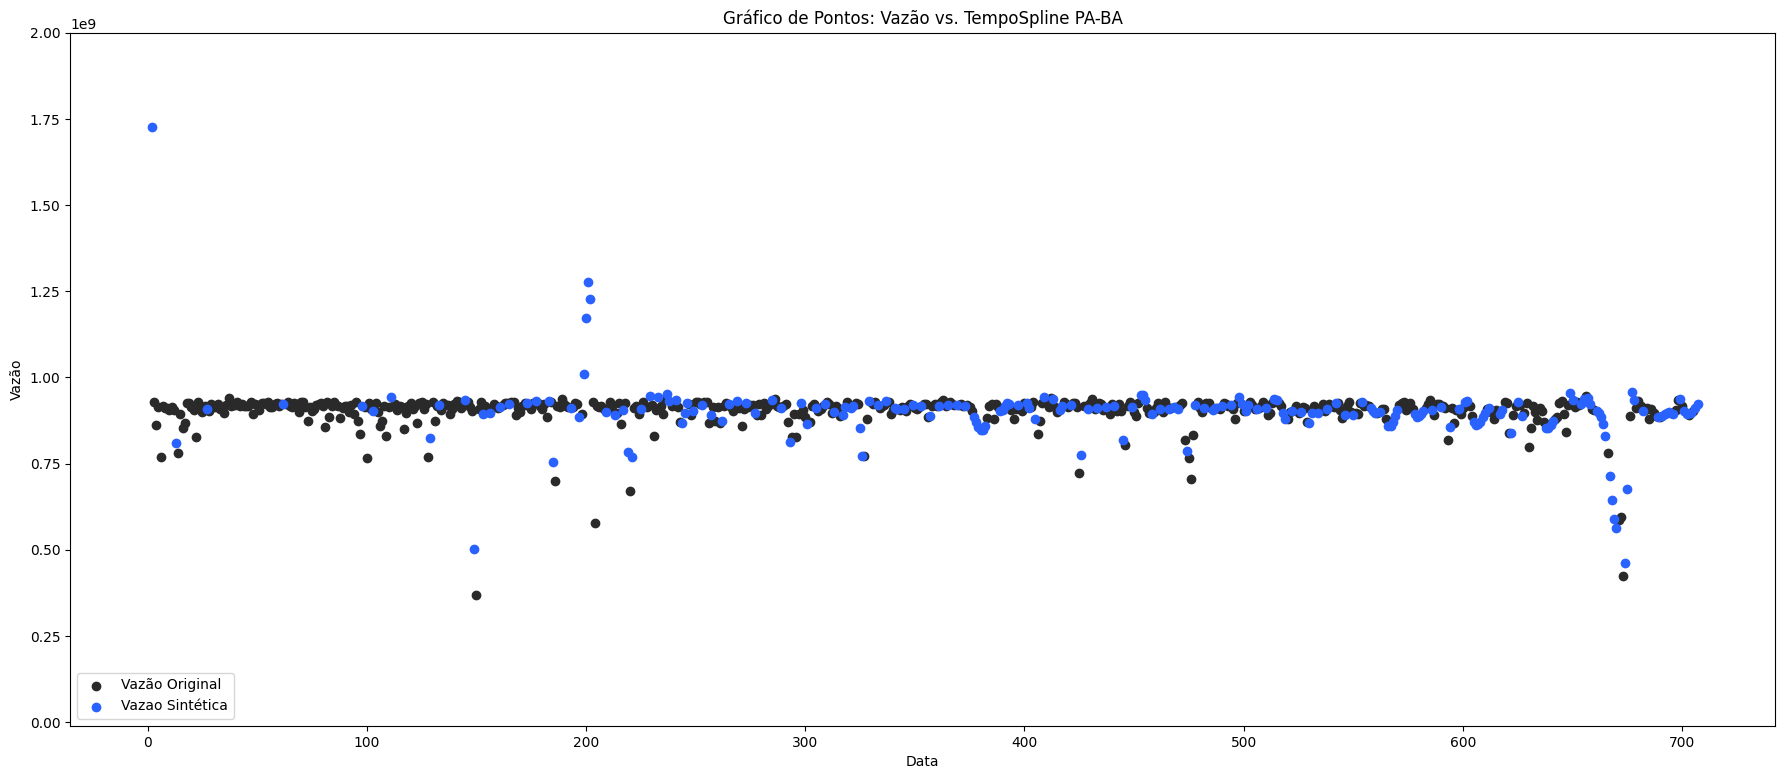

In [59]:
plot_grafico(df_imputado, df, "Spline PA-BA")

In [64]:
df_amostra = pd.read_csv("../../datasets/processados/amostras_com_dados_faltantes/vazao/bbr/06-10-2023/tratado bbr esmond data pa-ba 06-10-2023_longest_interval.csv")
df_imputado_amostra = imputacao_spline(df_amostra)
df_imputado_amostra.to_csv("../../datasets/processados/amostras_imputadas/vazao/bbr/06-10-2023/pa-ba/interp bspline.csv")

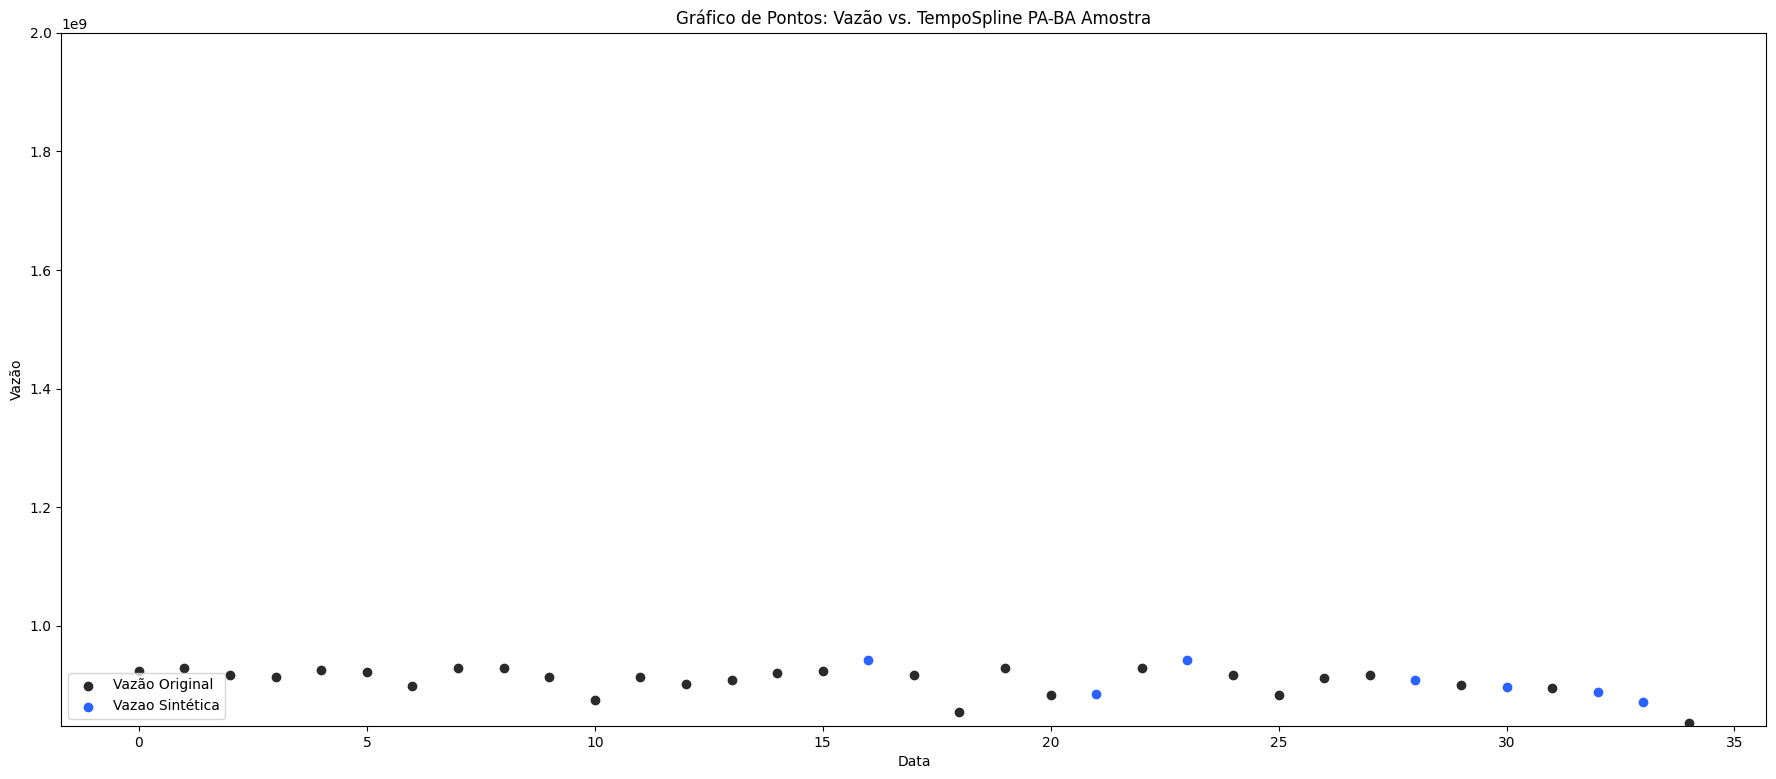

In [63]:
plot_grafico(df_imputado_amostra, df_amostra, "Spline PA-BA Amostra")

In [72]:
import os

todos_rmse_pa_ba_bbr_arr = []
# Gerando o RMSE de todos os datasets >bbr 06-10-2023 pa-ba<
todos_rmse_pa_ba_bbr = {}
df1 = pd.read_csv("../../datasets/processados/amostras_continuas/vazao/bbr/06-10-2023/tratado bbr esmond data pa-ba 06-10-2023_longest_interval.csv")
data1 = df1["Vazao"]
diretorio = "../../datasets/processados/amostras_imputadas/vazao/bbr/06-10-2023/pa-ba"
for arquivo in os.listdir(diretorio):
    df2 = pd.read_csv(os.path.join(diretorio, arquivo))
    data2 = df2["Vazao"]
    rmse_arq = calcular_rmse(data1, data2)
    todos_rmse_pa_ba_bbr[arquivo] = rmse_arq
    todos_rmse_pa_ba_bbr_arr.append(rmse_arq)

todos_rmse_pa_ba_bbr

{'interp bspline.csv': 10689182.621573737,
 'interp linear.csv': 10468885.033842487,
 'interp ponderada.csv': 8805815.526131367,
 'knn.csv': 8109773.582046466,
 'media movel.csv': 168158942.0490721,
 'mediana movel.csv': 7830837.119694228}

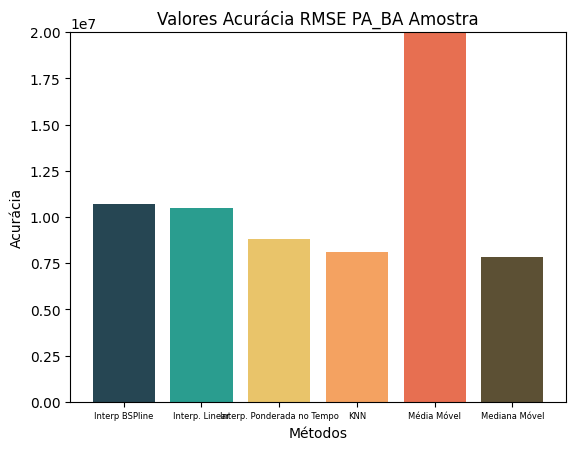

In [84]:
plotar_grafico_colunas(todos_rmse_pa_ba_bbr_arr, "RMSE PA_BA Amostra")

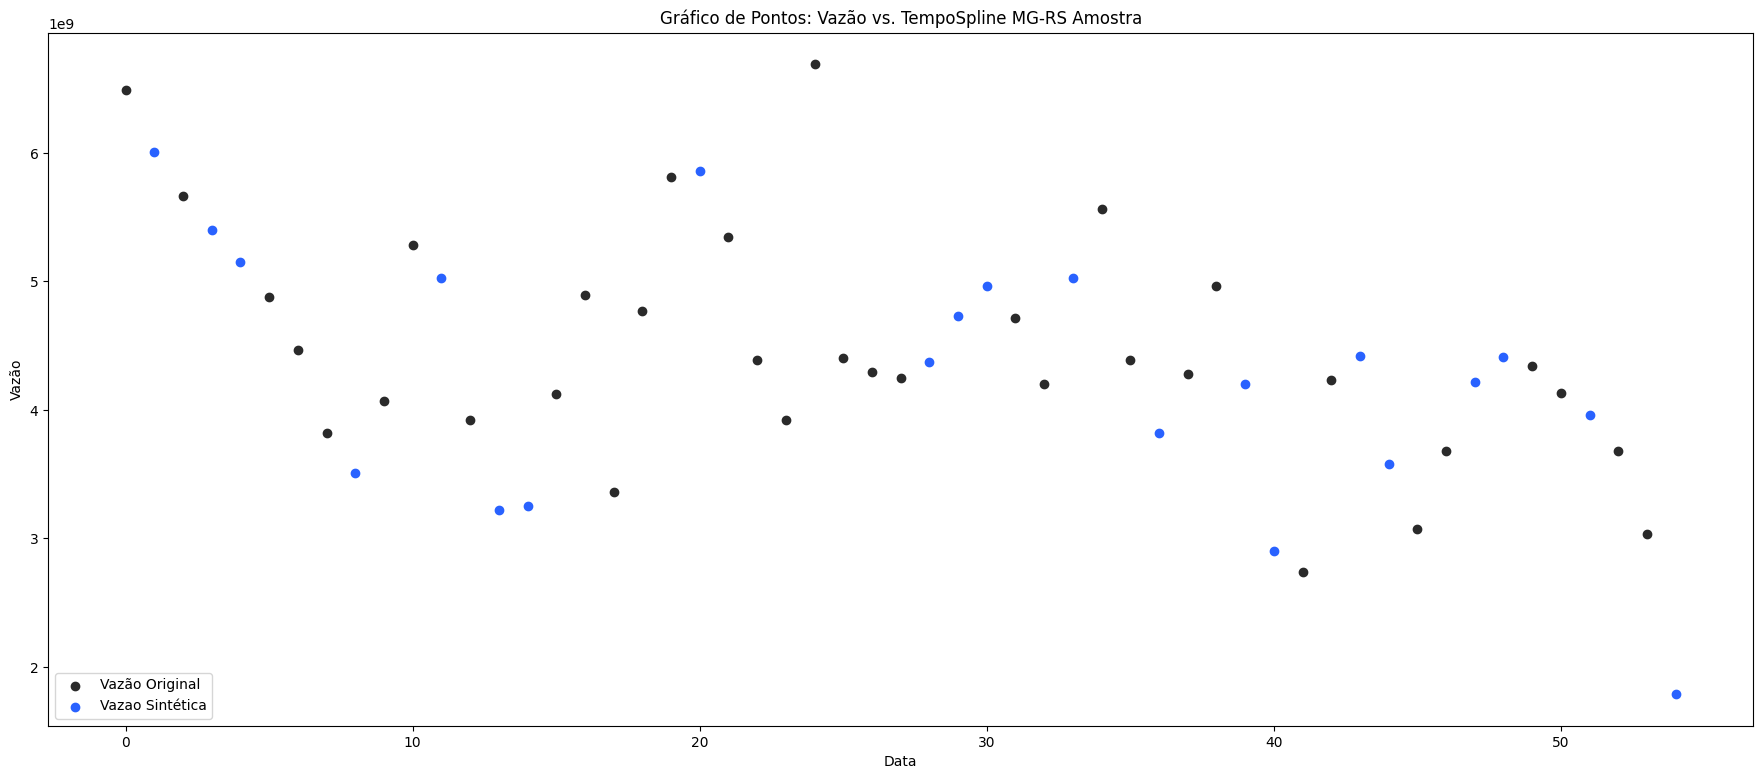

In [91]:
df_amostra = pd.read_csv("../../datasets/processados/amostras_com_dados_faltantes/vazao/bbr/06-10-2023/tratado bbr esmond data mg-rs 06-10-2023_longest_interval.csv")
df_imputado_amostra = imputacao_spline(df_amostra)
df_imputado_amostra.to_csv("../../datasets/processados/amostras_imputadas/vazao/bbr/06-10-2023/mg-rs/interp bspline.csv")

plot_grafico(df_imputado_amostra, df_amostra, "Spline MG-RS Amostra")

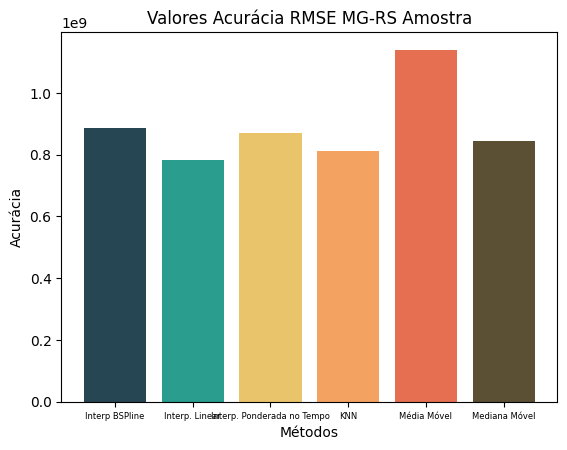

In [8]:
import os

todos_rmse_mg_rs_bbr_arr = []
# Gerando o RMSE de todos os datasets >bbr 06-10-2023 pa-ba<
todos_rmse_mg_rs_bbr = {}
df1 = pd.read_csv("../../datasets/processados/amostras_continuas/vazao/bbr/06-10-2023/tratado bbr esmond data mg-rs 06-10-2023_longest_interval.csv")
data1 = df1["Vazao"]
diretorio = "../../datasets/processados/amostras_imputadas/vazao/bbr/06-10-2023/mg-rs"
for arquivo in os.listdir(diretorio):
    df2 = pd.read_csv(os.path.join(diretorio, arquivo))
    data2 = df2["Vazao"]
    rmse_arq = calcular_rmse(data1, data2)
    todos_rmse_mg_rs_bbr[arquivo] = rmse_arq
    todos_rmse_mg_rs_bbr_arr.append(rmse_arq)

plotar_grafico_colunas(todos_rmse_mg_rs_bbr_arr, "RMSE MG-RS Amostra")

In [23]:
import os
import pandas as pd

In [24]:
def plot_vazao(df):
    valid_vazao = df[df['original'] != -1]['original']
    plt.scatter(valid_vazao.index, valid_vazao, color='#2a2a2a', label='Vazão Original')

def plot_sintetico(df):
    df['Vazao_Sintetica'] = np.where(df['Sintético'] == '1', df['Vazao'], np.nan)
    valid_vazao_sintetica = df[df['Vazao_Sintetica'].notnull()]['Vazao_Sintetica']
    plt.scatter(valid_vazao_sintetica.index, valid_vazao_sintetica, color='#2962ff', label='Vazao Sintética')

def criar_sintetico(df, df_original):
    df["original"] = df_original["Vazao"]
    df["Sintético"] = np.where(df_original["Vazao"] == -1, '1', '0')

    return df

def plot_grafico(df,df_original, protocolo, nome, tipo, output_path):
    df = criar_sintetico(df, df_original)
    plt.figure(figsize=(22, 9))
    plot_vazao(df)
    plot_sintetico(df)
    # plt.ylim(ymax=2000000000)
    # plt.xlim(xmin=200, xmax=300)
    plt.xlabel('Data')
    plt.ylabel('Vazão')
    plt.title('Gráfico Vazão vs. Tempo Método de Imputação: ' + tipo + " " + protocolo + " " + nome )
    plt.legend(loc='lower left')
    plt.savefig(output_path)

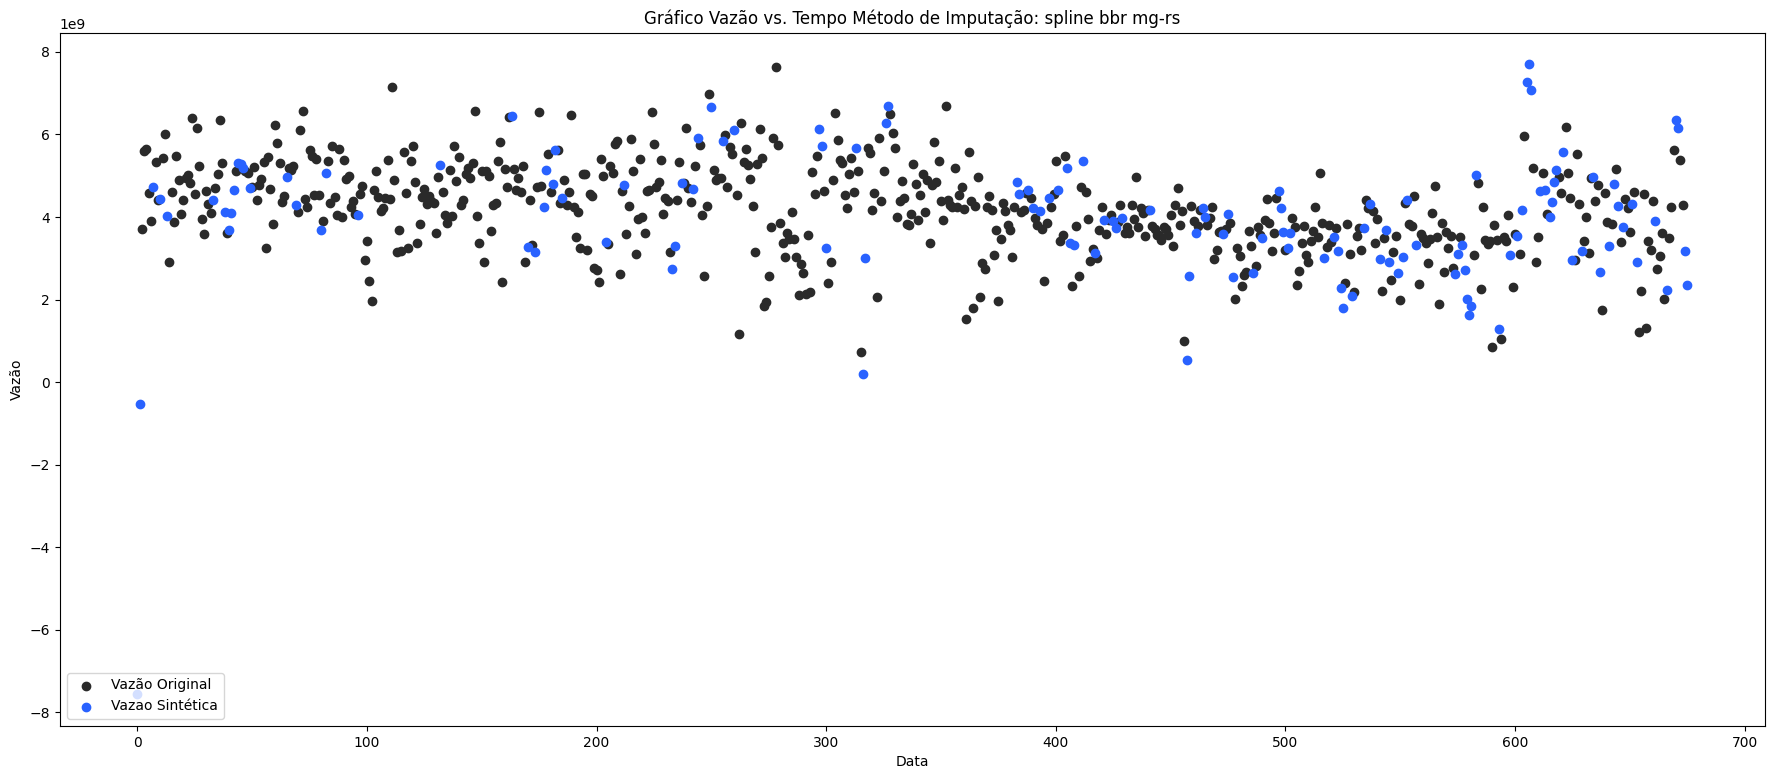

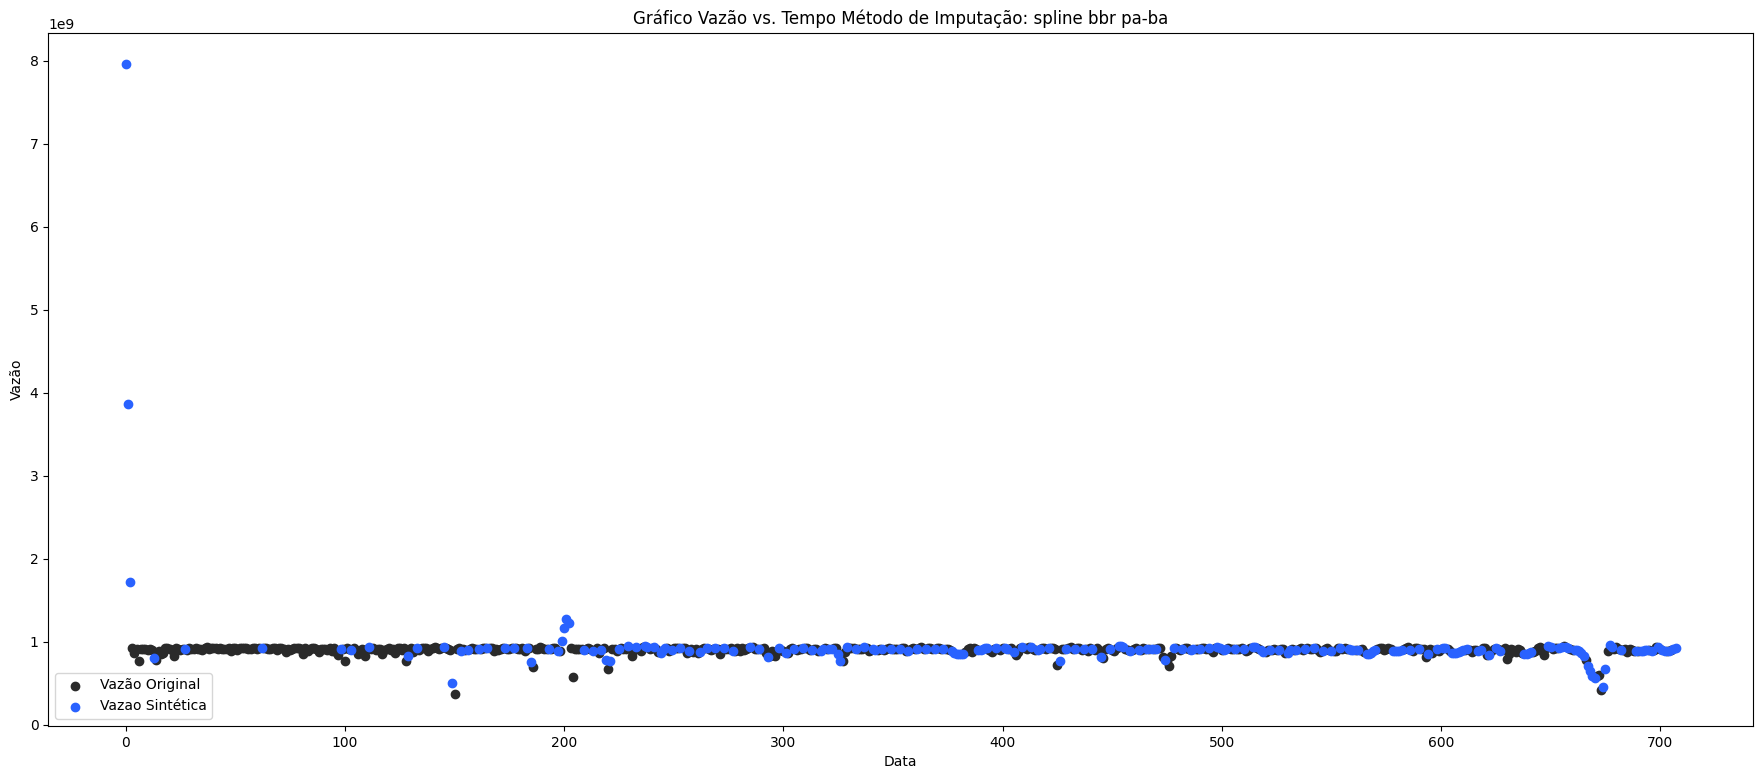

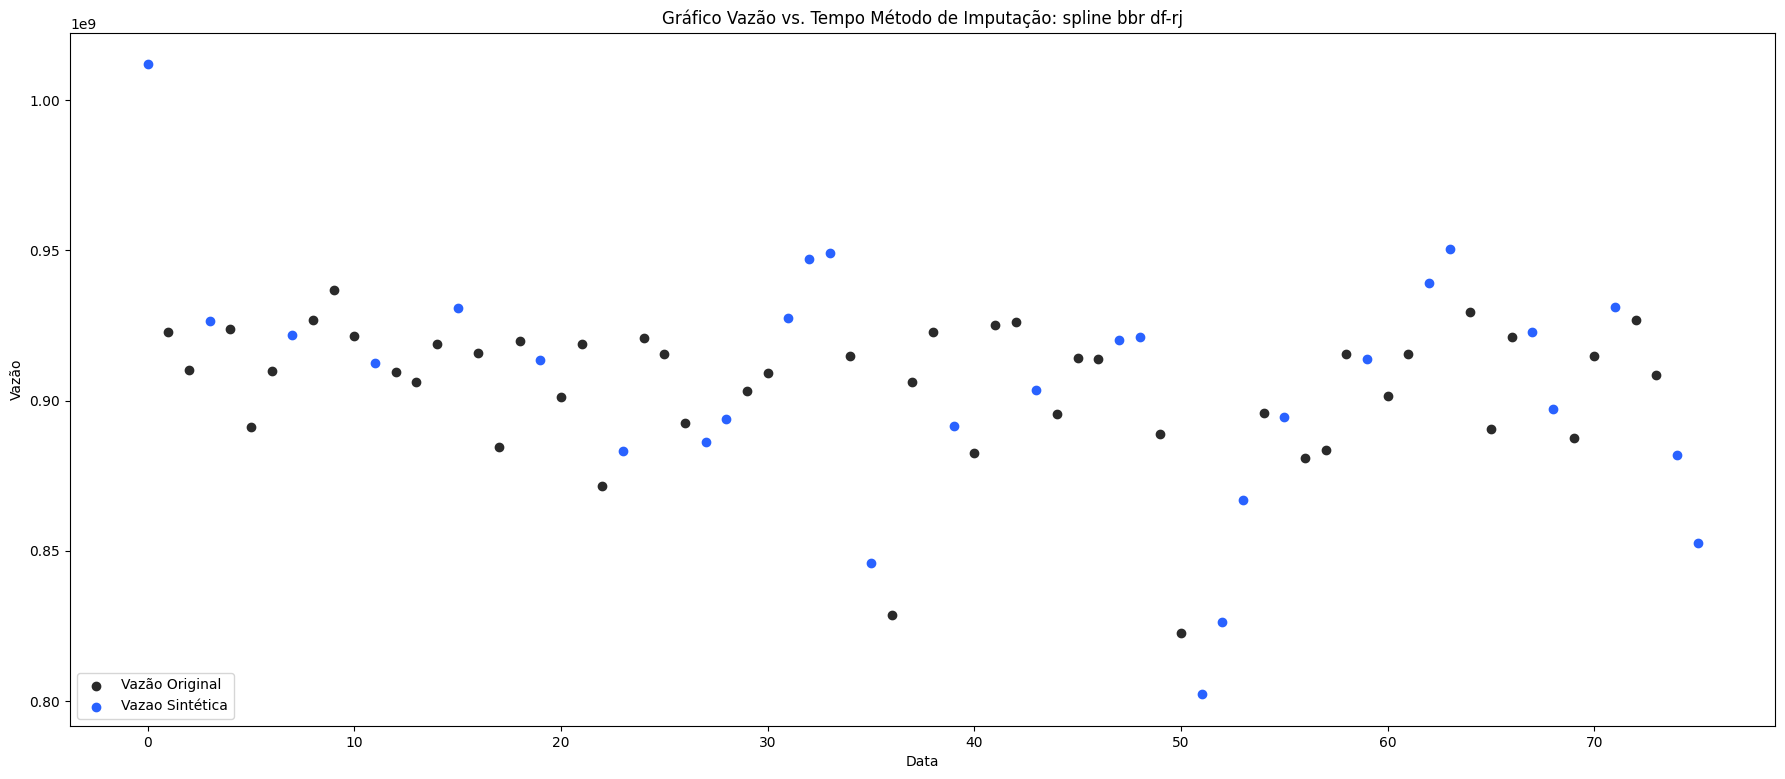

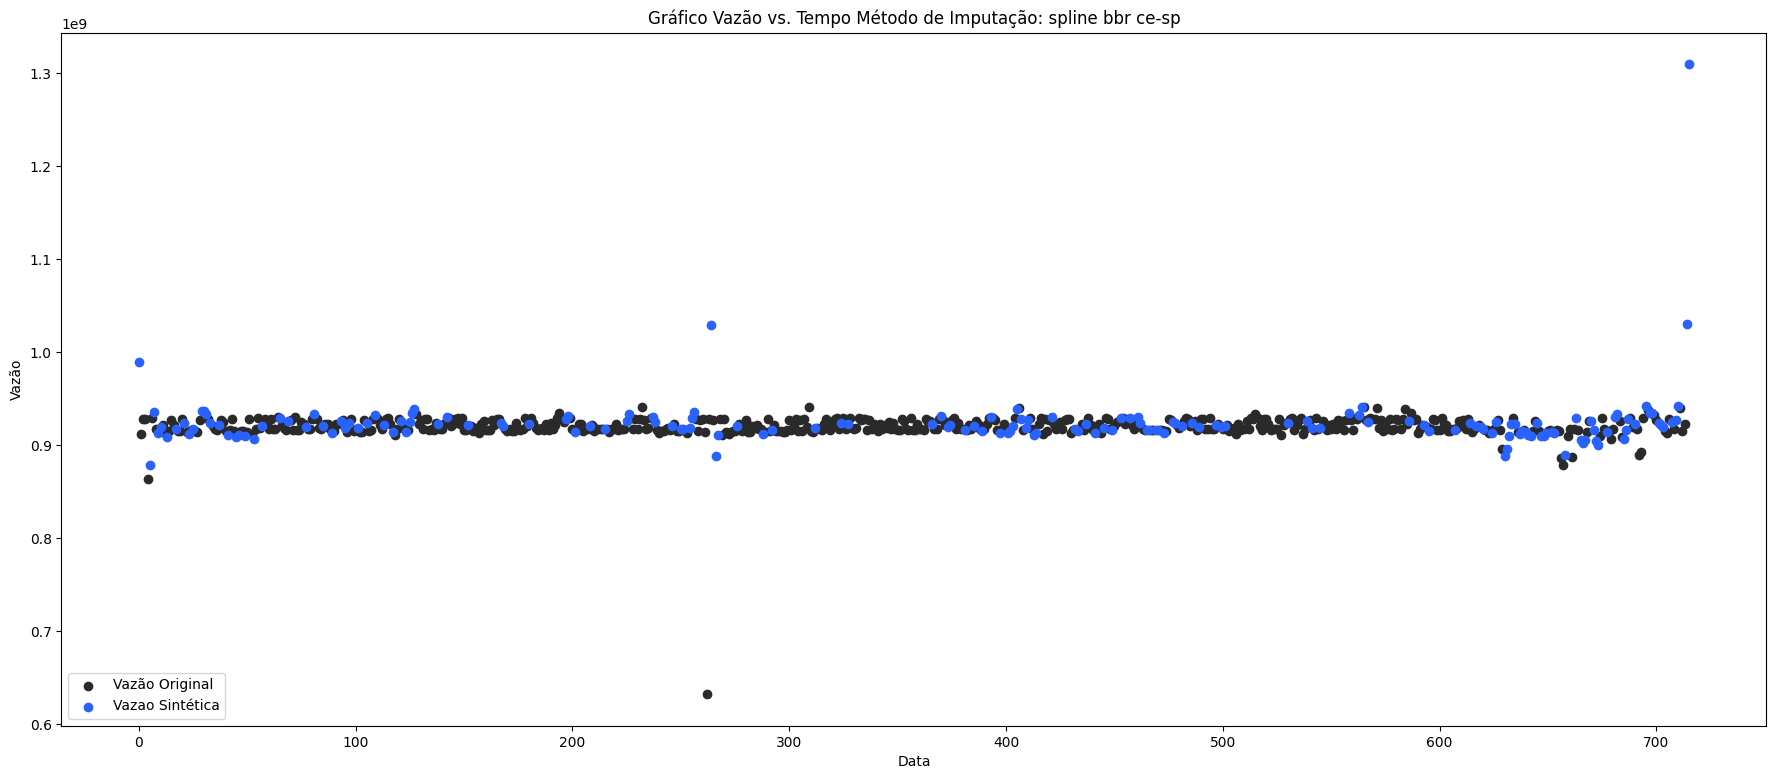

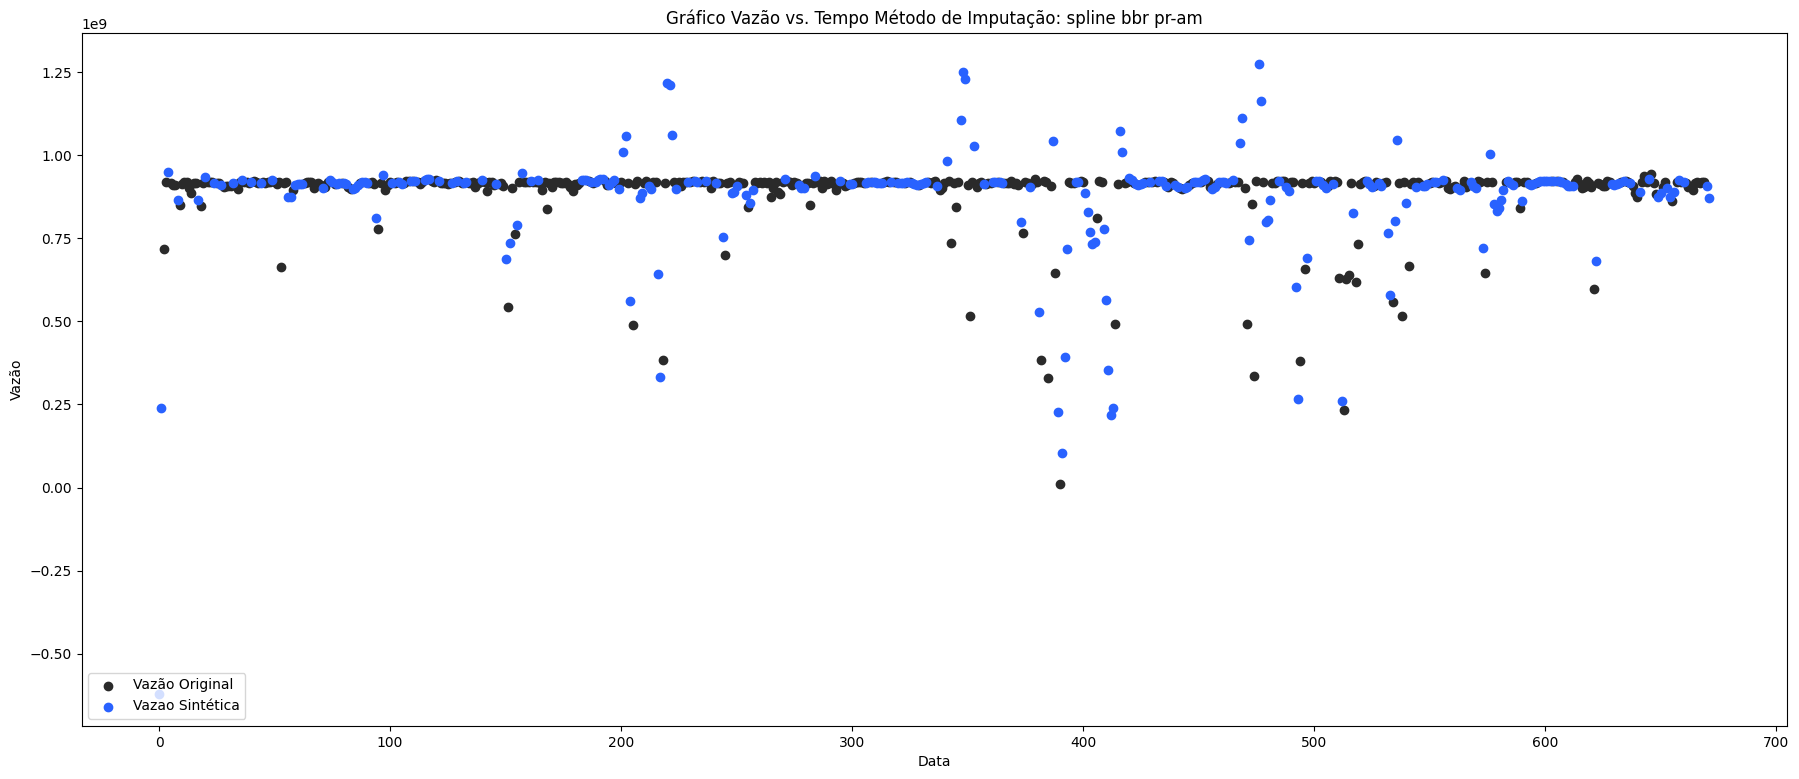

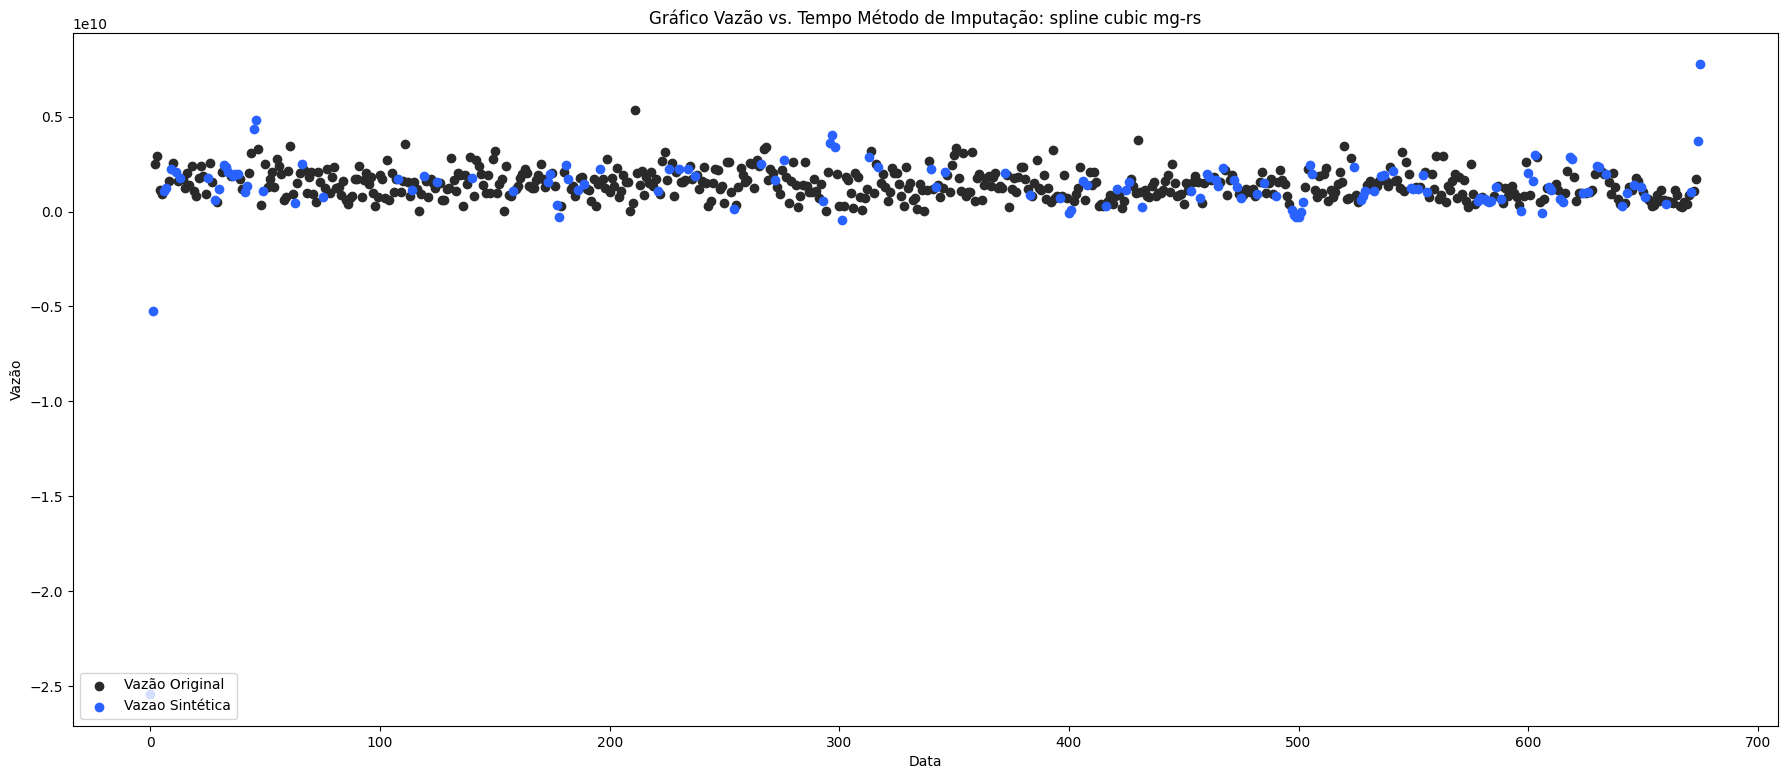

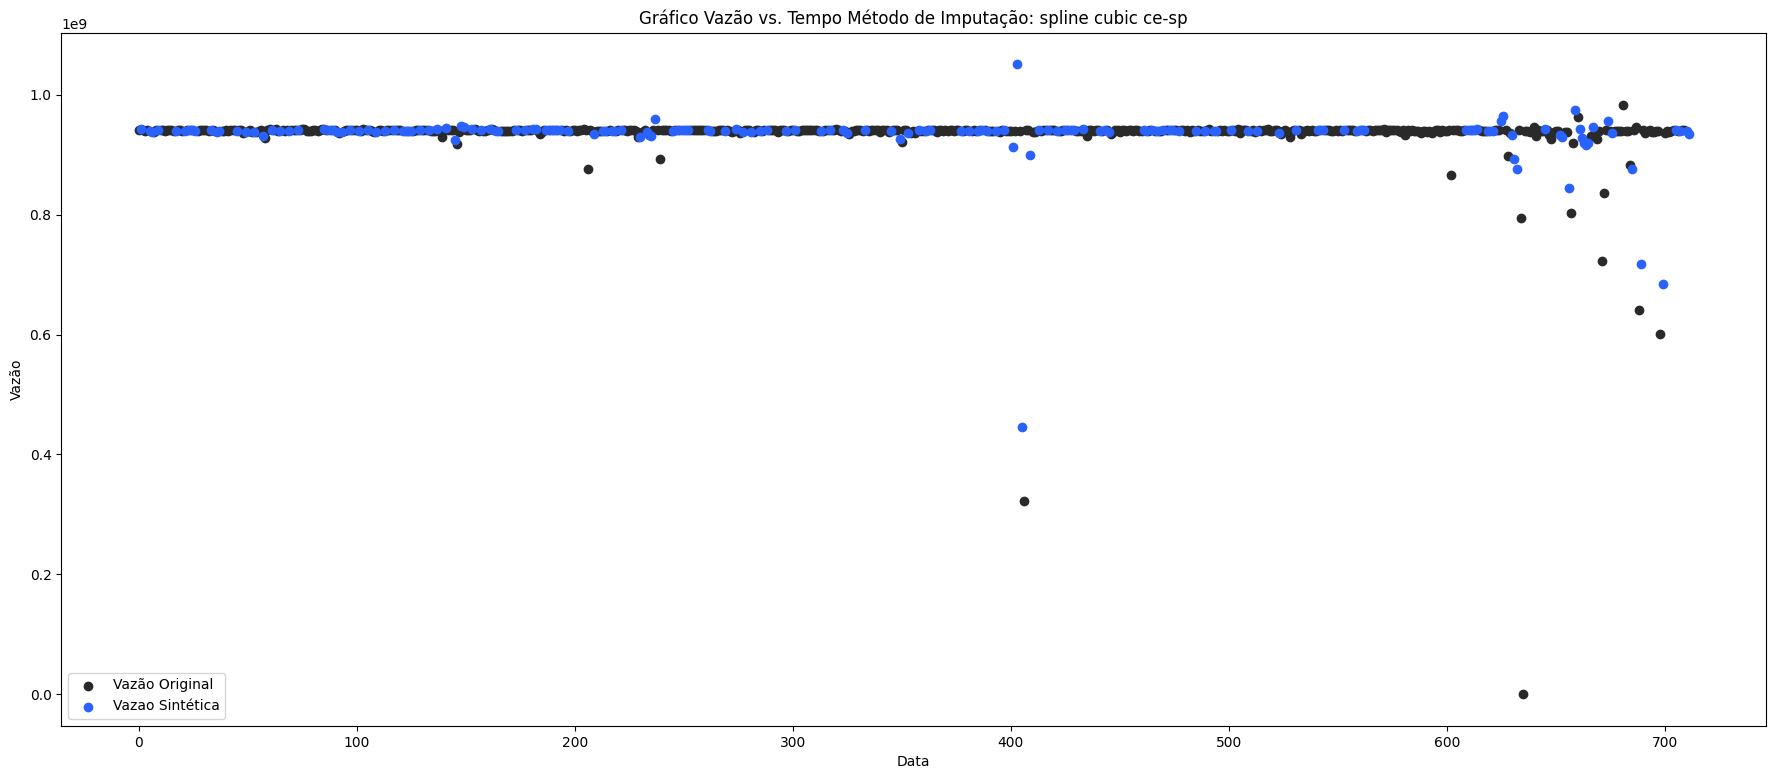

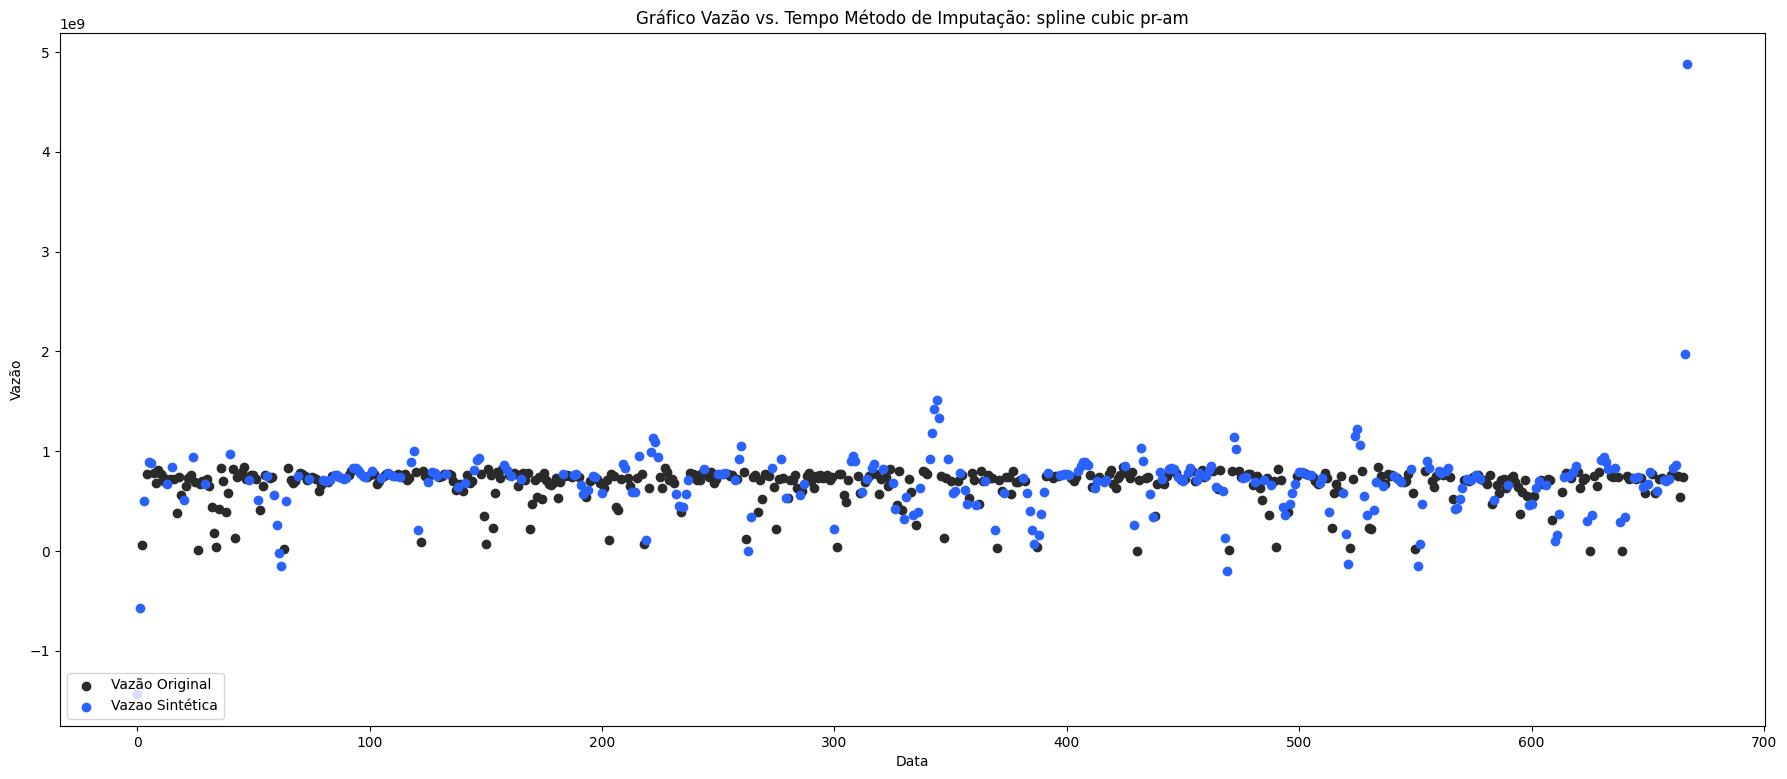

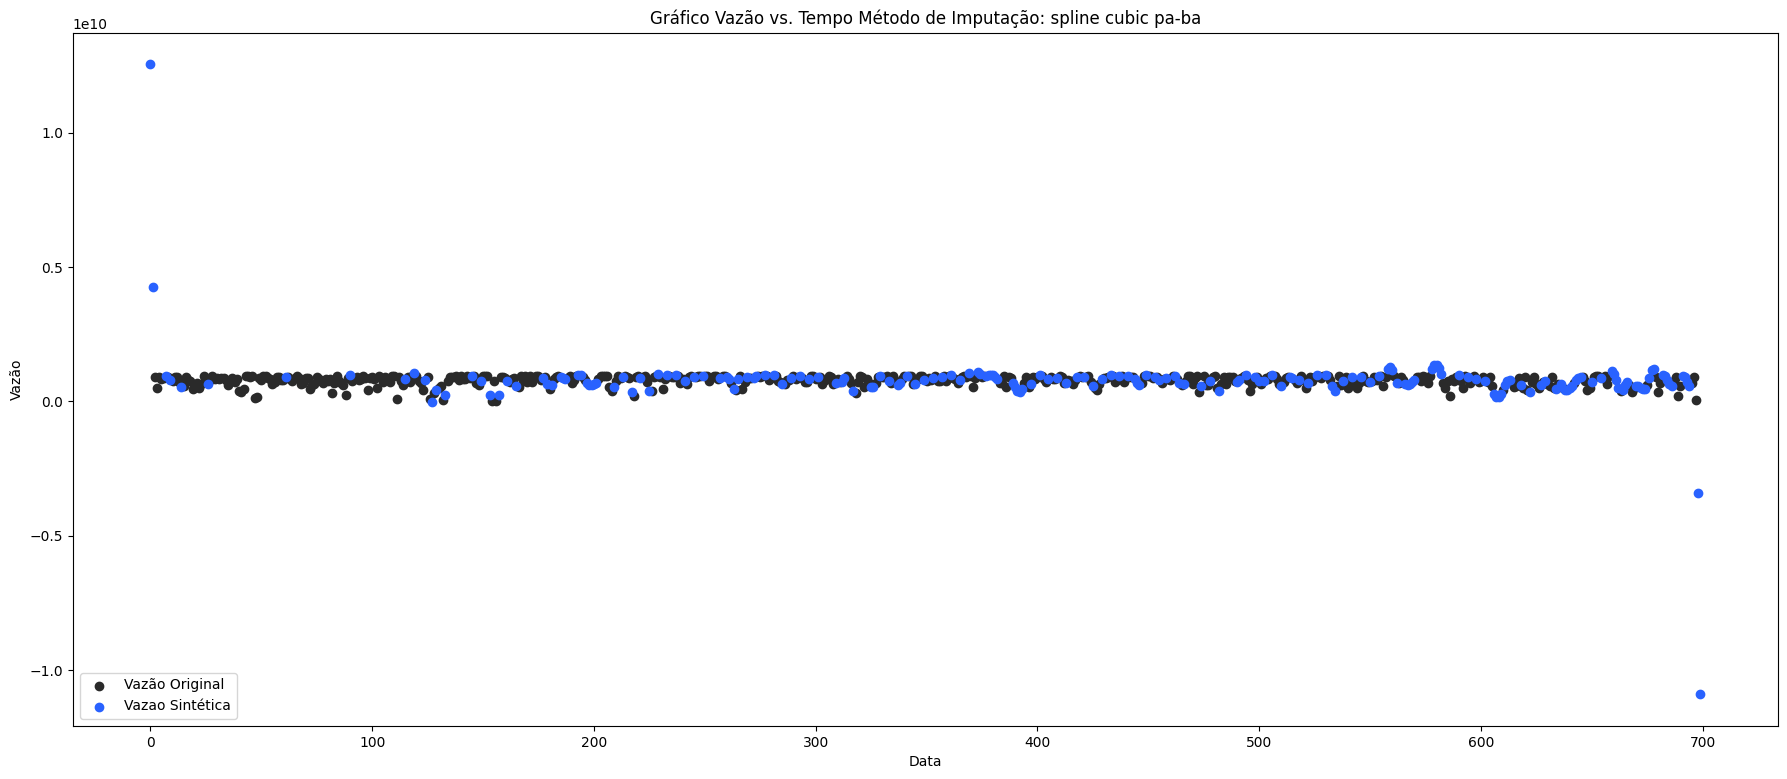

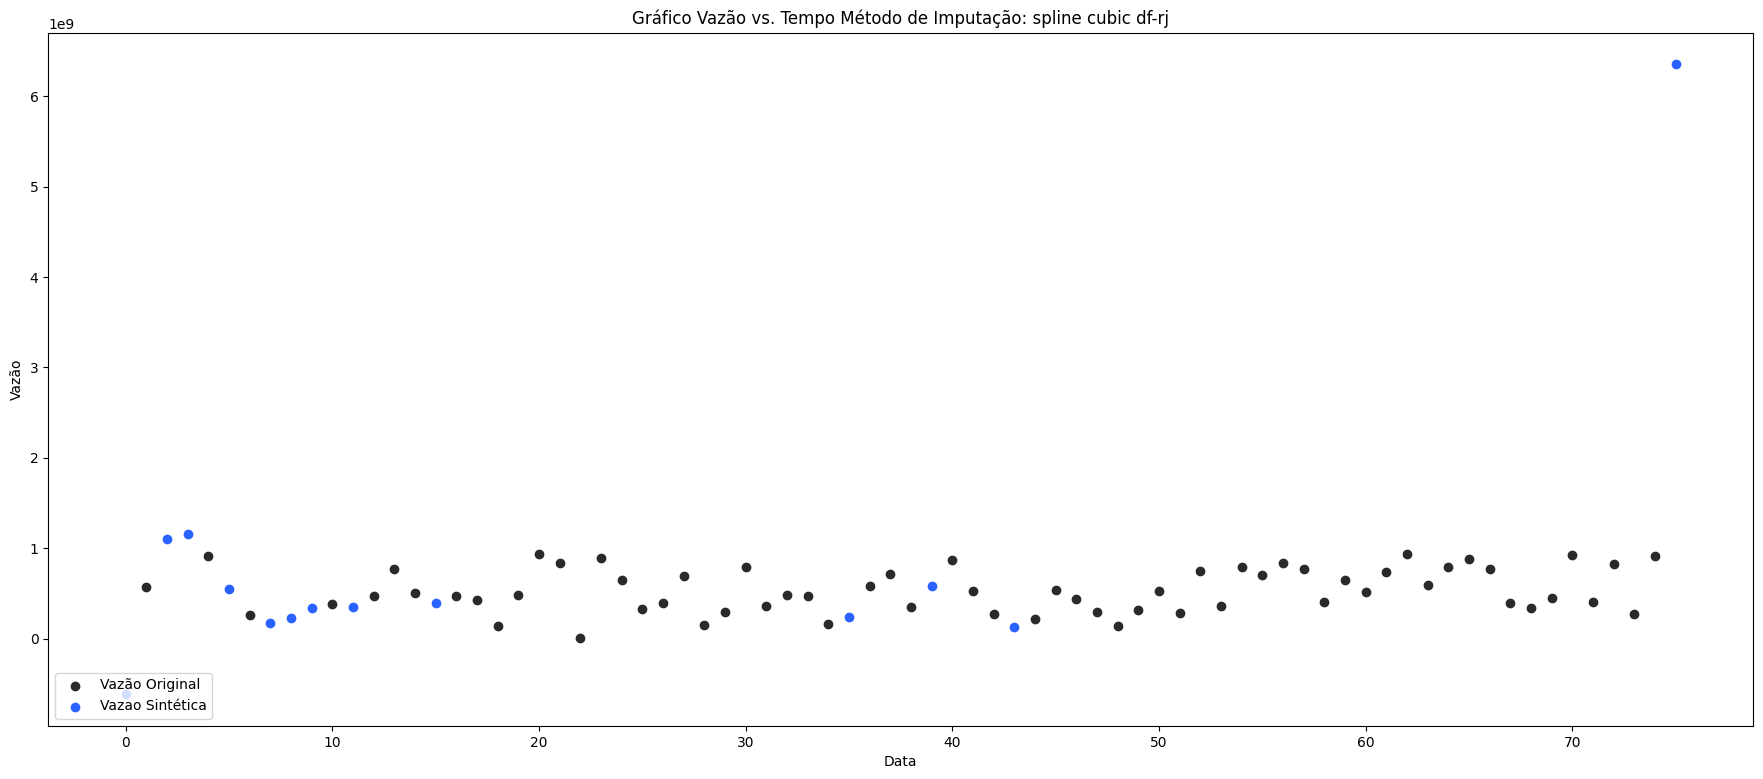

In [27]:
# Percorrendo todos os datasets tratados de vazão bbr e cubic 06-10-2023

tratados = "../../datasets/processados/tratados/10-06-2023"
protocolos = ['bbr', 'cubic']

for protocolo in protocolos:
    caminho_tratados = os.path.join(tratados, protocolo)
    for arquivo in os.listdir(caminho_tratados):
        caminho_arquivo = os.path.join(caminho_tratados, arquivo)
        if caminho_arquivo.endswith('.csv'):
            if "ce-sp" in arquivo: nome = "ce-sp"
            if "mg-rs" in arquivo: nome = "mg-rs"
            if "pa-ba" in arquivo: nome = "pa-ba"
            if "pr-am" in arquivo: nome = "pr-am"
            if "df-rj" in arquivo: nome = "df-rj"
            df = pd.read_csv(caminho_arquivo)
            df_imputado = imputacao_spline(df)
            caminho_arquivo_imputado = ("../../datasets/processados/tratados_imputados/vazao/" + protocolo + "/" + nome + "/" + "preenchido " + protocolo + " esmond data " + nome + " 06-10-2023_spline.csv")
            df.to_csv(caminho_arquivo_imputado)
            caminho_plot_scatter = ("../../graficos/scatter/tratados-imputados/spline " + protocolo + " " + nome + " 06-10-2023.png")
            plot_grafico(df_imputado, df, protocolo, nome, "spline", caminho_plot_scatter)
            #print(caminho_plot_scatter)